In [1]:
import warnings;warnings.filterwarnings('ignore')

import re
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

import lightgbm as lgb
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

# 1.데이터 로드

In [2]:
data_path = '../data'
train_path = f'{data_path}/new/new_train_ver6.csv'
test_path  = f'{data_path}/new/new_test_ver6.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
print('Train data shape : ', train_data.shape, 'Test data shape : ', test_data.shape)

Train data shape :  (1118822, 192) Test data shape :  (9272, 191)


In [3]:
# train/test 구분을 위한 칼럼 생성.
train_data['is_test'] = 0
test_data['is_test'] = 1
df = pd.concat([train_data, test_data]) # 하나의 데이터로 합친다.

In [4]:
drop_columns = ["해제사유발생일", "등기신청일자", "k-사용검사일-사용승인일", "k-등록일자", "k-수정일자", "단지승인일", "단지신청일", "계약날짜"]

df = df.drop(columns=drop_columns)

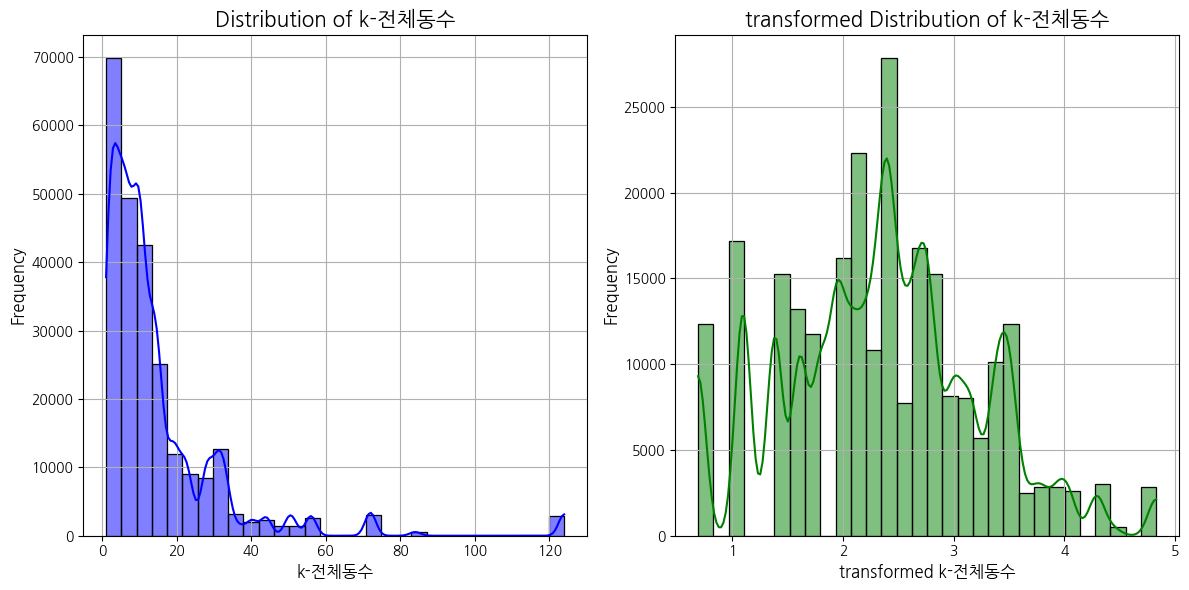

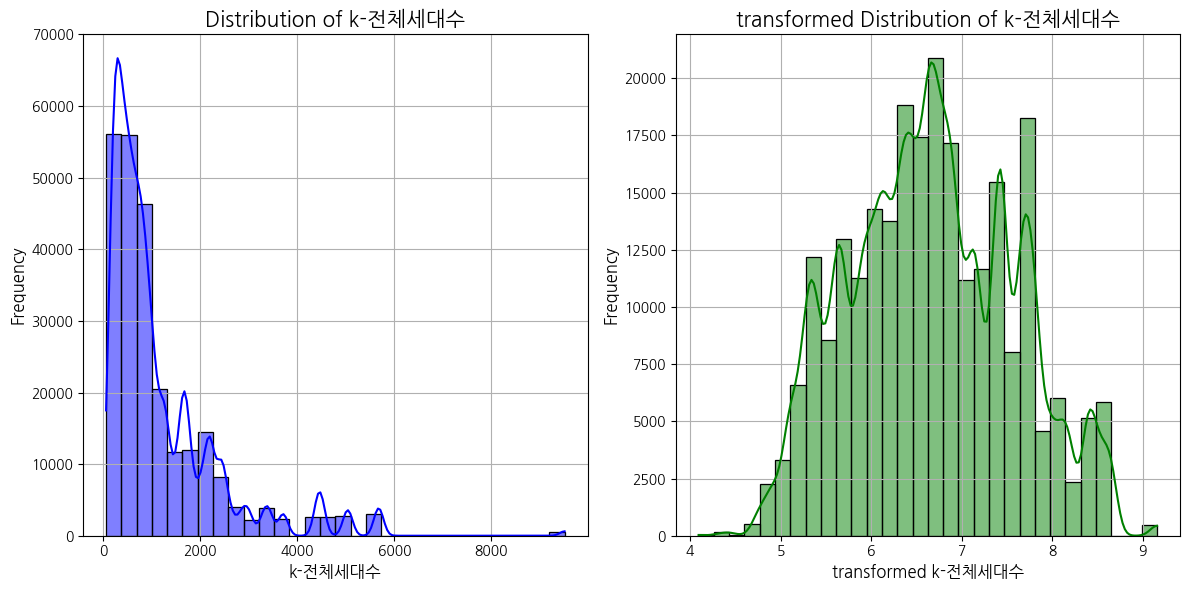

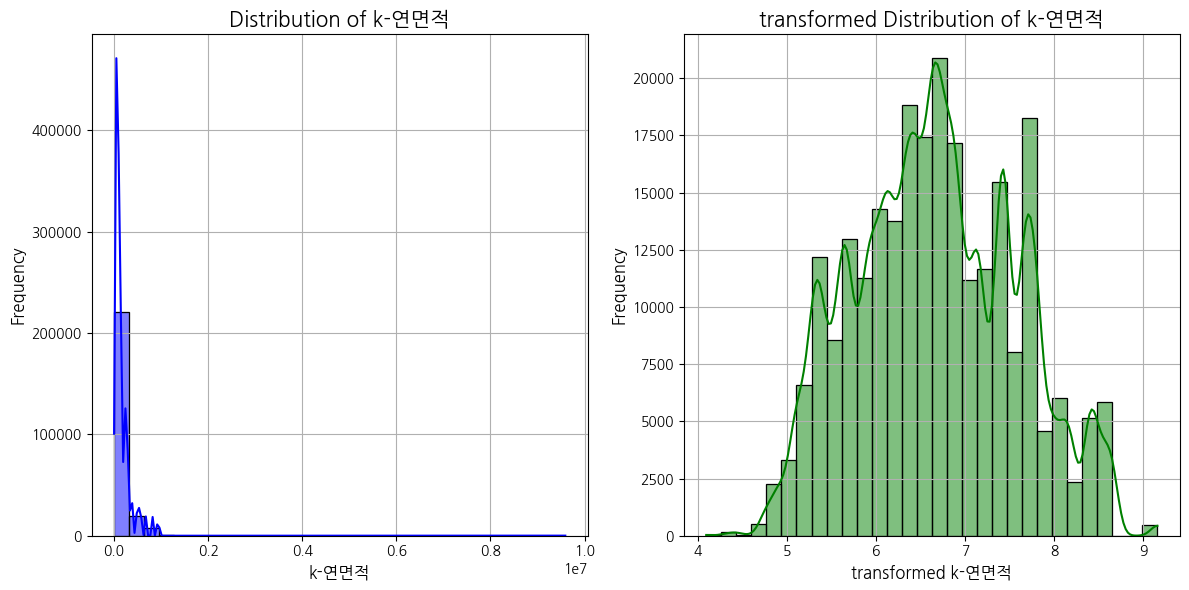

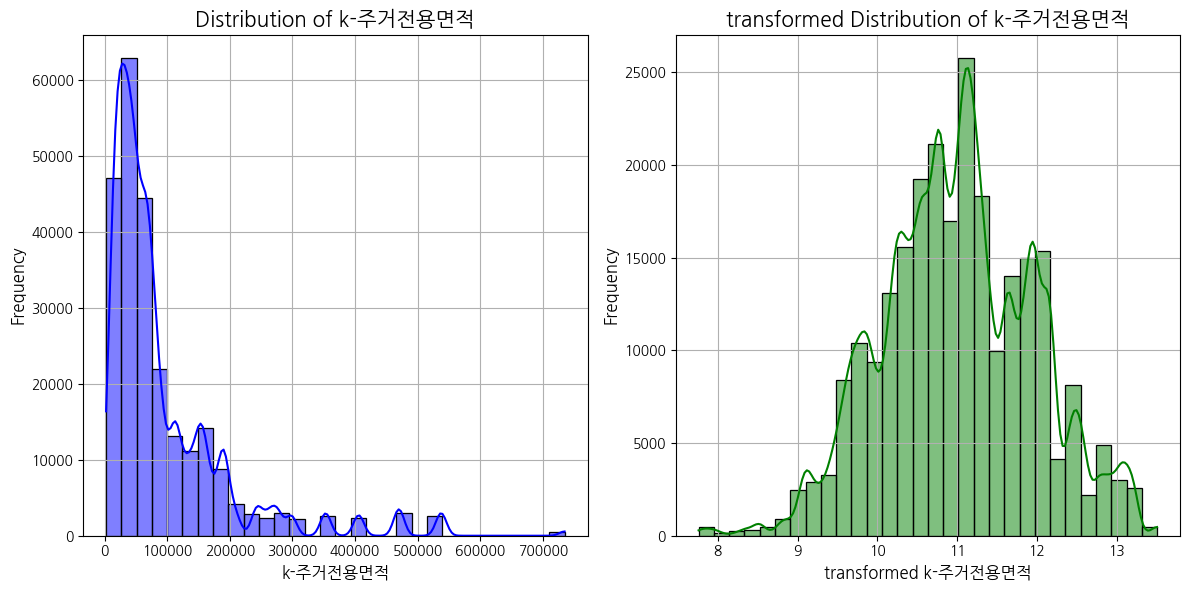

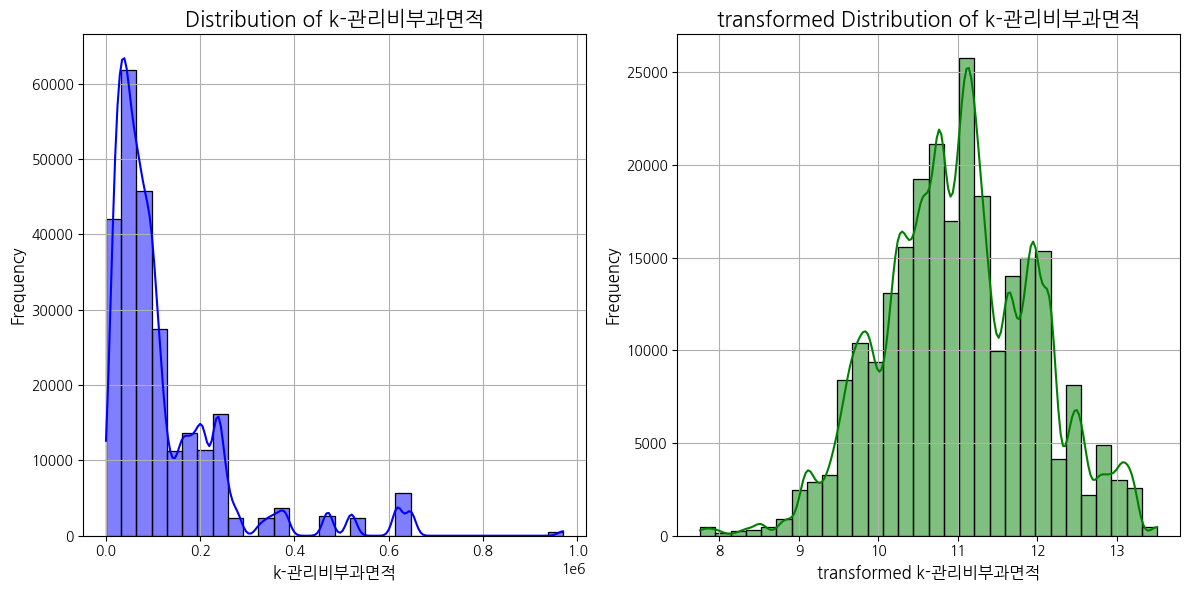

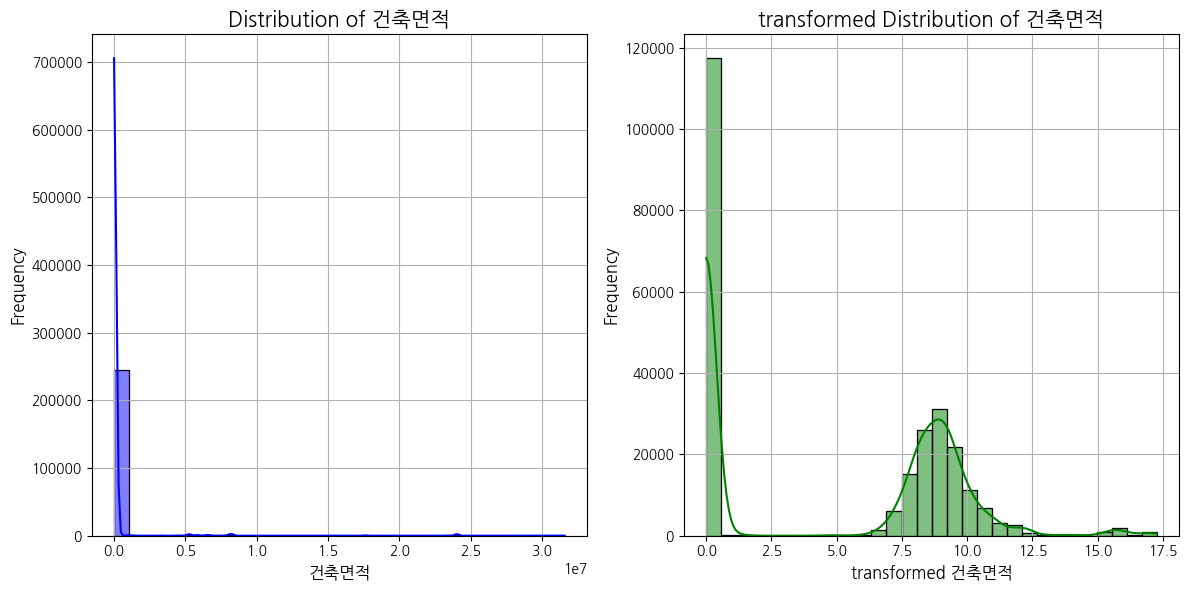

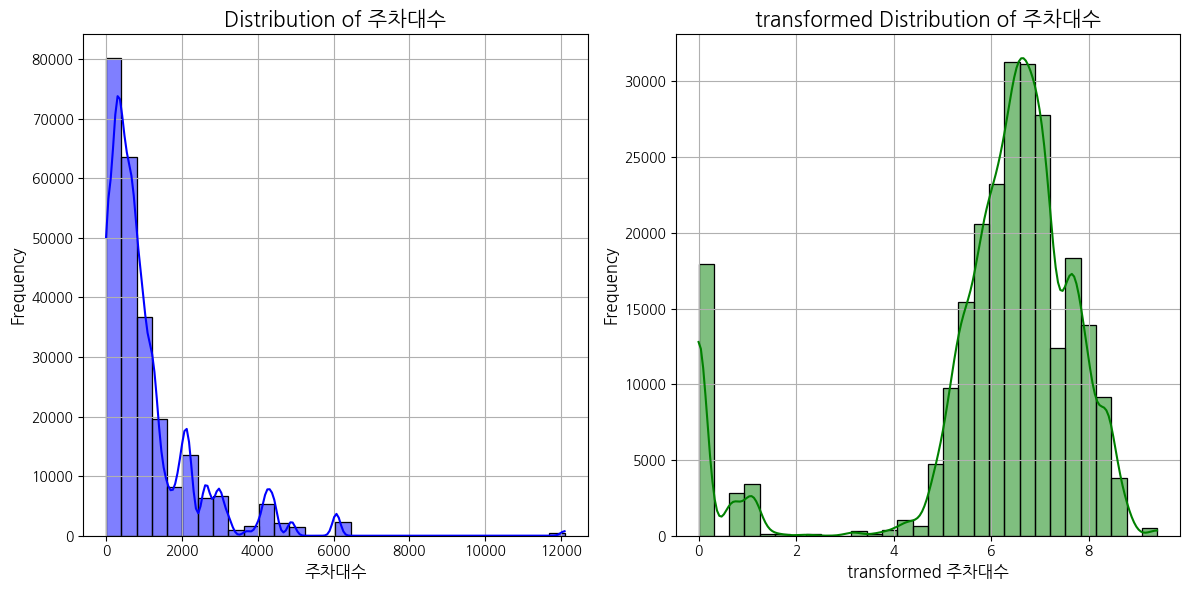

In [5]:
columns_to_visualize = ['k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '건축면적', '주차대수']

for column in columns_to_visualize:
    plt.figure(figsize=(12, 6))
    
    # 원래 데이터의 분포
    plt.subplot(1, 2, 1)
    sns.histplot(train_data[column].dropna(), kde=True, bins=30, color='blue', edgecolor='k')
    plt.title(f'Distribution of {column}', fontsize=15)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    
    # 로그 변환한 데이터의 분포
    plt.subplot(1, 2, 2)
    if column == "k-연면적" or column == "k-관리비부과면적":
        sqrt_transformed = np.sqrt(train_data[column].dropna())
    else:
        log_transformed = np.log1p(train_data[column].dropna())

    sns.histplot(log_transformed, kde=True, bins=30, color='green', edgecolor='k')
    plt.title(f'transformed Distribution of {column}', fontsize=15)
    plt.xlabel(f'transformed {column}', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 2.연속형 변수 예측

In [6]:
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'subsample': 0.8, 
    'num_leaves': 127, 
    'n_estimators': 1000, 
    'min_child_samples': 30, 
    'learning_rate': 0.1, 
    'feature_fraction': 0.7, 
    'colsample_bytree': 0.7, 
    'bagging_freq': 1, 
    'bagging_fraction': 0.7,
    'verbose': -1
}

num_boost_round = 100000
original_data = copy.deepcopy(df)
drop_columns = ['k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '건축면적', '주차대수']

for target_column in drop_columns:
    # 현재 타겟 컬럼을 drop_columns에서 제외
    current_drop_columns = drop_columns.copy()
    current_drop_columns.remove(target_column)
    
    train_set = copy.deepcopy(df)
    train_set = train_set.drop(columns=current_drop_columns + ['아파트명', '도로명', 'k-건설사', 'target'])
    
    # 결측치가 없는 행과 있는 행을 분리
    train_data_non_missing = train_set.dropna(subset=[target_column])
    train_data_missing = train_set[train_set[target_column].isnull()]
    
    if train_data_missing.shape[0] == 0:
        # 결측치가 없는 경우, 다음 타겟 컬럼으로 넘어감
        continue
    
    # 학습에 사용할 피처와 타겟 변수를 설정
    X = train_data_non_missing.drop(columns=[target_column])
    y = train_data_non_missing[target_column]
    
    # 결측치를 예측할 피처를 설정
    X_test = train_data_missing.drop(columns=[target_column])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_preds = np.zeros(X_test.shape[0])
    
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        train_data_lgb = lgb.Dataset(X_train, label=y_train)
        valid_data_lgb = lgb.Dataset(X_valid, label=y_valid, reference=train_data_lgb)
        
        model = lgb.train(params, 
                          train_data_lgb, 
                          valid_sets=[train_data_lgb, valid_data_lgb],
                          num_boost_round=num_boost_round,
                          callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])
        
        y_preds += model.predict(X_test, num_iteration=model.best_iteration) / kf.n_splits
    
    df.loc[df[target_column].isnull(), target_column] = y_preds

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 6.31387	valid_1's rmse: 6.42149
[20]	training's rmse: 2.39319	valid_1's rmse: 2.44748
[30]	training's rmse: 1.06175	valid_1's rmse: 1.10689
[40]	training's rmse: 0.622887	valid_1's rmse: 0.670423
[50]	training's rmse: 0.458476	valid_1's rmse: 0.510193
[60]	training's rmse: 0.383052	valid_1's rmse: 0.439538
[70]	training's rmse: 0.328231	valid_1's rmse: 0.391675
[80]	training's rmse: 0.292071	valid_1's rmse: 0.360437
[90]	training's rmse: 0.266773	valid_1's rmse: 0.341854
[100]	training's rmse: 0.246476	valid_1's rmse: 0.326065
[110]	training's rmse: 0.229769	valid_1's rmse: 0.313648
[120]	training's rmse: 0.21281	valid_1's rmse: 0.300917
[130]	training's rmse: 0.198433	valid_1's rmse: 0.291497
[140]	training's rmse: 0.18838	valid_1's rmse: 0.284429
[150]	training's rmse: 0.177929	valid_1's rmse: 0.277091
[160]	training's rmse: 0.16846	valid_1's rmse: 0.270508
[170]	training's rmse: 0.159319	valid_1's rms

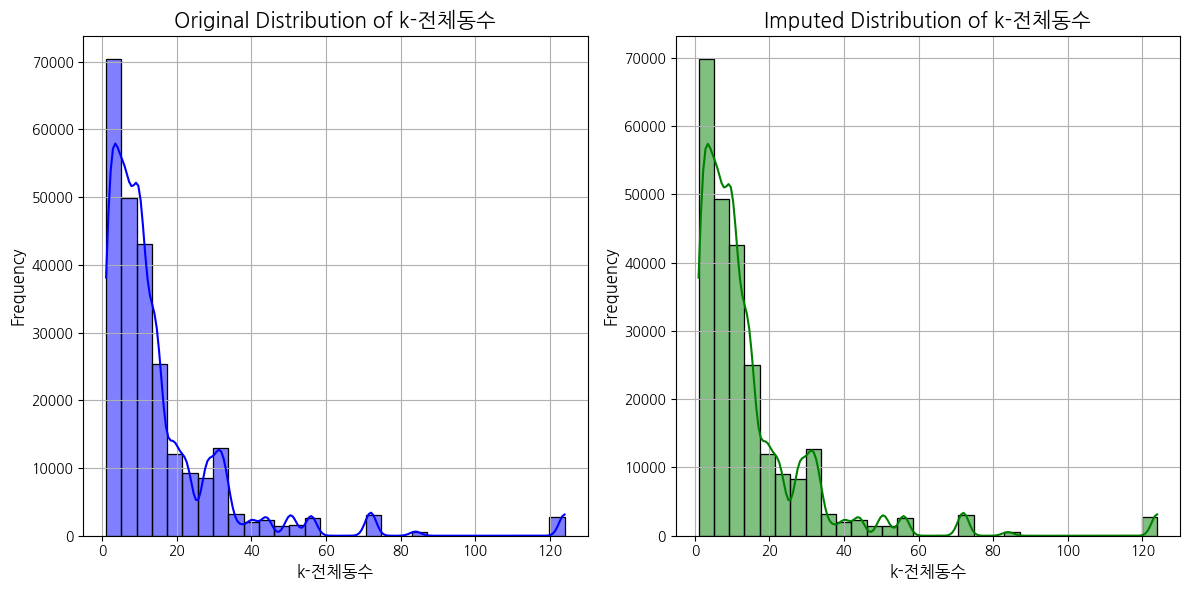

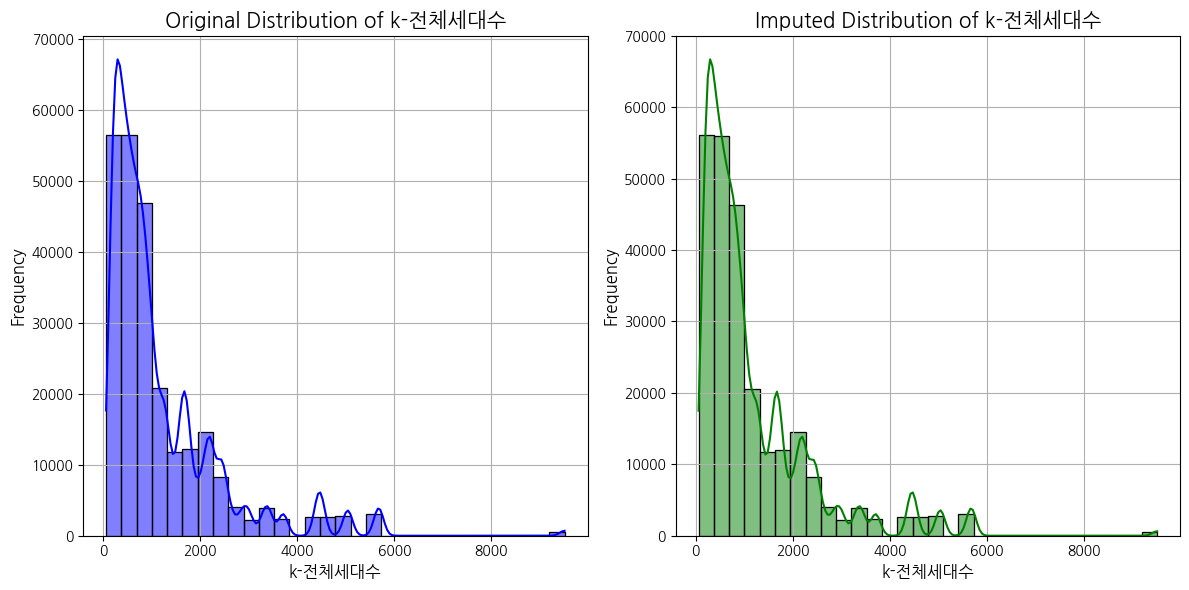

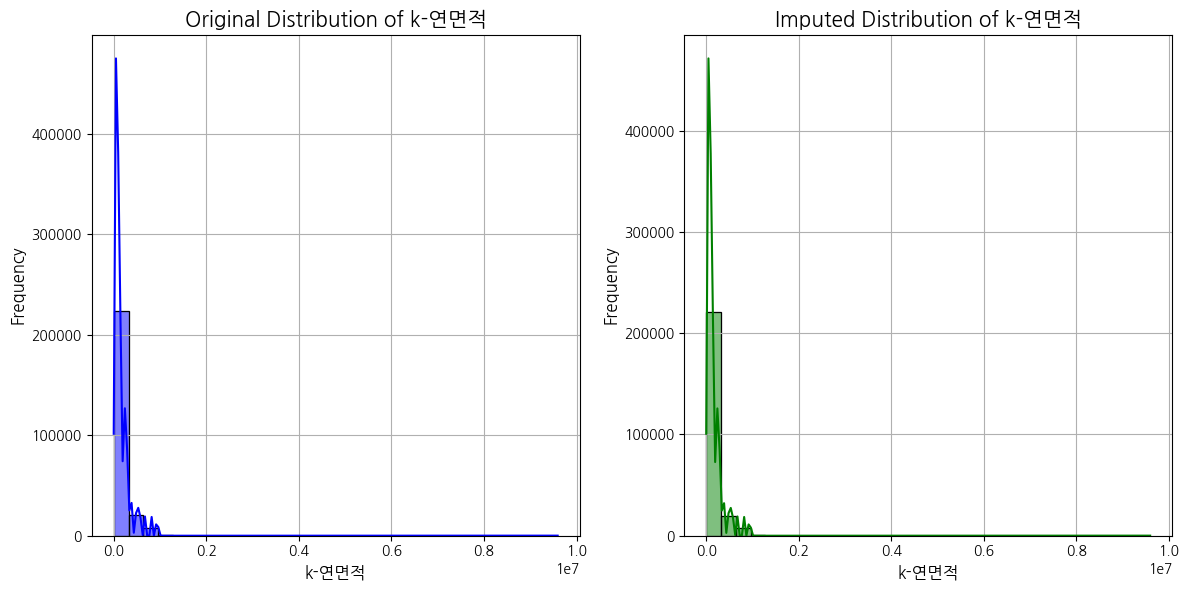

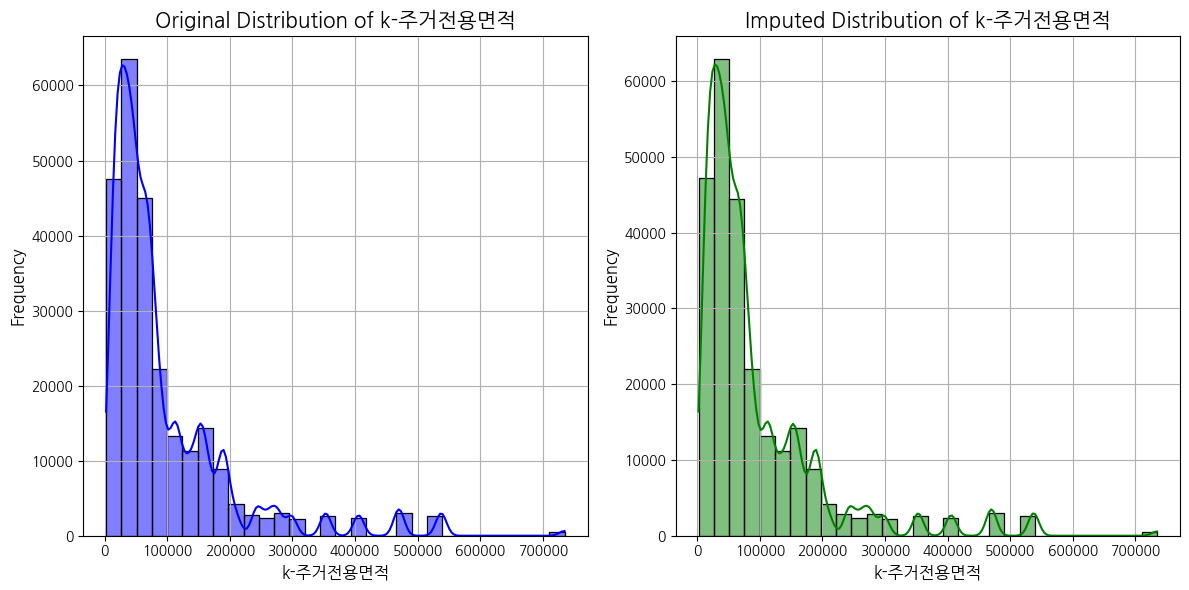

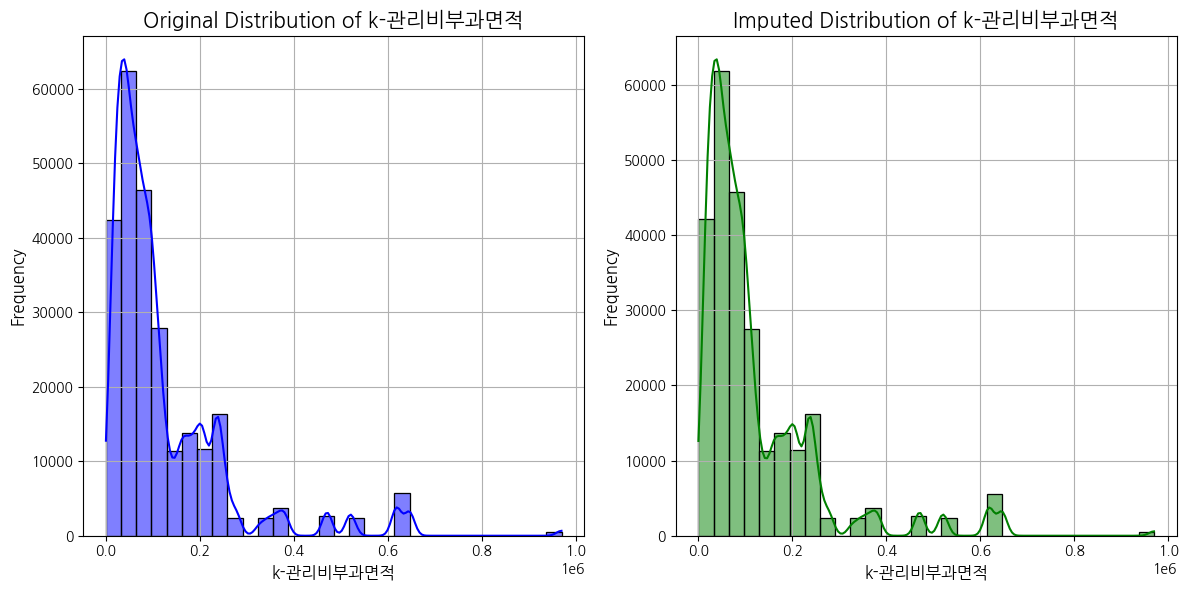

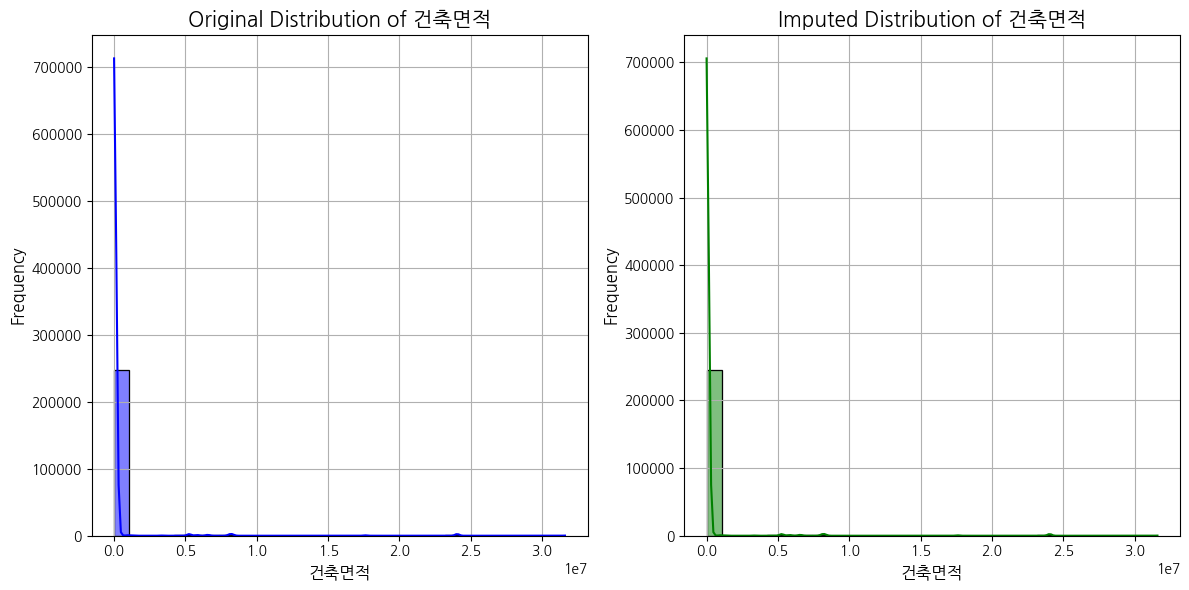

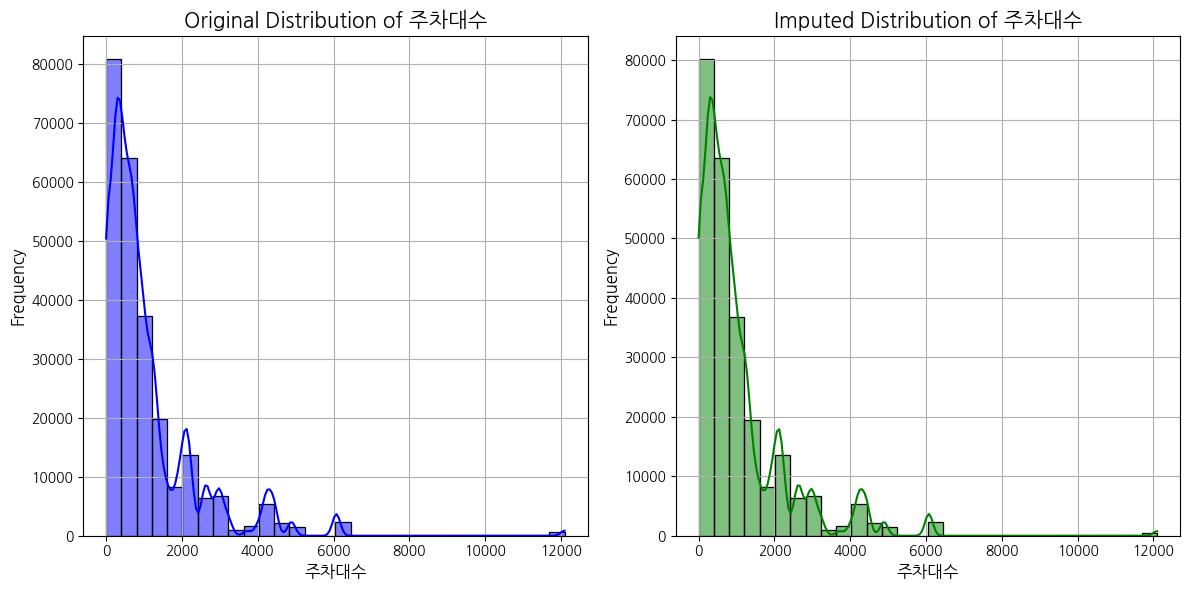

In [7]:
for column in drop_columns:
    plt.figure(figsize=(12, 6))
    
    # 예측 이전 분포
    plt.subplot(1, 2, 1)
    sns.histplot(original_data[column].dropna(), kde=True, bins=30, color='blue', edgecolor='k')
    plt.title(f'Original Distribution of {column}', fontsize=15)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    
    # 예측 이후 분포
    plt.subplot(1, 2, 2)
    sns.histplot(train_data[column].dropna(), kde=True, bins=30, color='green', edgecolor='k')
    plt.title(f'Imputed Distribution of {column}', fontsize=15)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [8]:
num_boost_round = 100000
original_data = copy.deepcopy(df)
categorical_columns = ['분양형태', 'k-관리방식', 'k-복도유형', 'k-난방방식']
# drop_columns = ['k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '건축면적', '주차대수']

for target_column in categorical_columns:
    # 파라미터 설정
    params = {
        'objective': 'multiclass',
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',
        'subsample': 0.8, 
        'num_leaves': 127, 
        'n_estimators': 1000, 
        'min_child_samples': 30, 
        'learning_rate': 0.1, 
        'feature_fraction': 0.7, 
        'colsample_bytree': 0.7, 
        'bagging_freq': 1, 
        'bagging_fraction': 0.7,
        'verbose': -1,
        'num_class': df[target_column].nunique()  # num_class는 각 범주형 변수의 클래스 수로 설정
    }

    train_set = copy.deepcopy(df)
    # train_set = train_set.drop(columns=drop_columns + ['아파트명', '도로명', 'k-건설사', 'target'])
    train_set = train_set.drop(columns=['아파트명', '도로명', 'k-건설사', 'target'])
    
    # 결측치가 없는 행과 있는 행을 분리
    train_data_non_missing = train_set.dropna(subset=[target_column])
    train_data_missing = train_set[train_set[target_column].isnull()]
    
    if train_data_missing.shape[0] == 0:
        # 결측치가 없는 경우, 다음 타겟 컬럼으로 넘어감
        continue
    
    # 학습에 사용할 피처와 타겟 변수를 설정
    X = train_data_non_missing.drop(columns=[target_column])
    y = train_data_non_missing[target_column].astype('category')
    
    # 결측치를 예측할 피처를 설정
    X_test = train_data_missing.drop(columns=[target_column])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_preds = np.zeros((X_test.shape[0], df[target_column].nunique()))
    
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        train_data_lgb = lgb.Dataset(X_train, label=y_train)
        valid_data_lgb = lgb.Dataset(X_valid, label=y_valid, reference=train_data_lgb)
        
        model = lgb.train(params, 
                          train_data_lgb, 
                          valid_sets=[train_data_lgb, valid_data_lgb],
                          num_boost_round=num_boost_round,
                          callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])
        
        y_preds += model.predict(X_test, num_iteration=model.best_iteration) / kf.n_splits
    
    # 예측값 중 가장 높은 확률을 가진 클래스로 대체
    y_pred_classes = np.argmax(y_preds, axis=1)
    df.loc[df[target_column].isnull(), target_column] = y_pred_classes

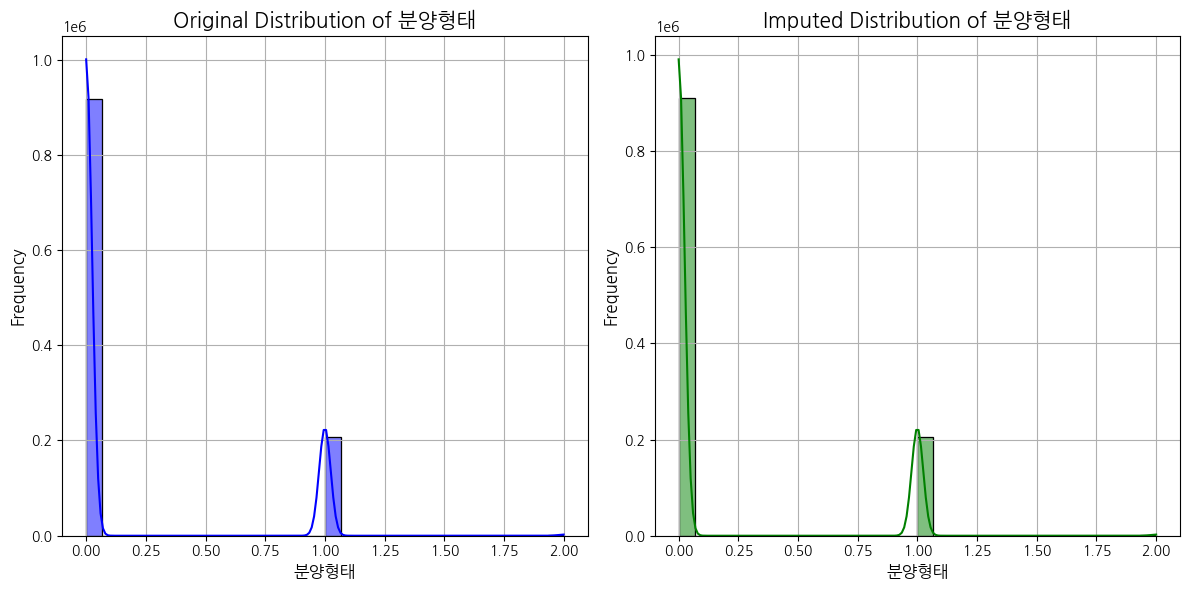

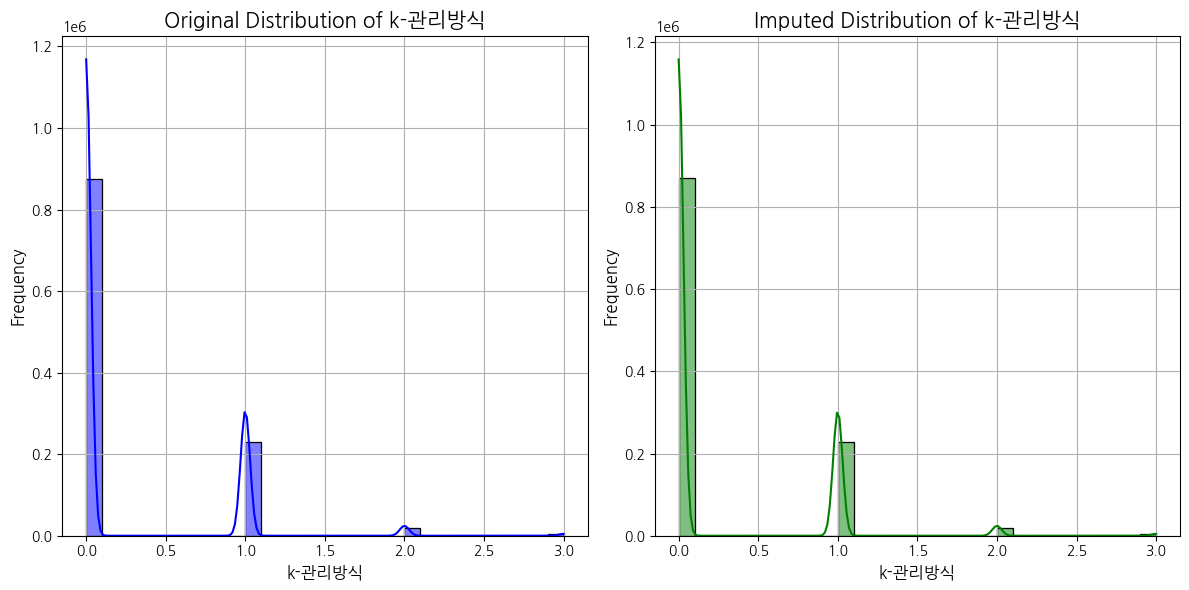

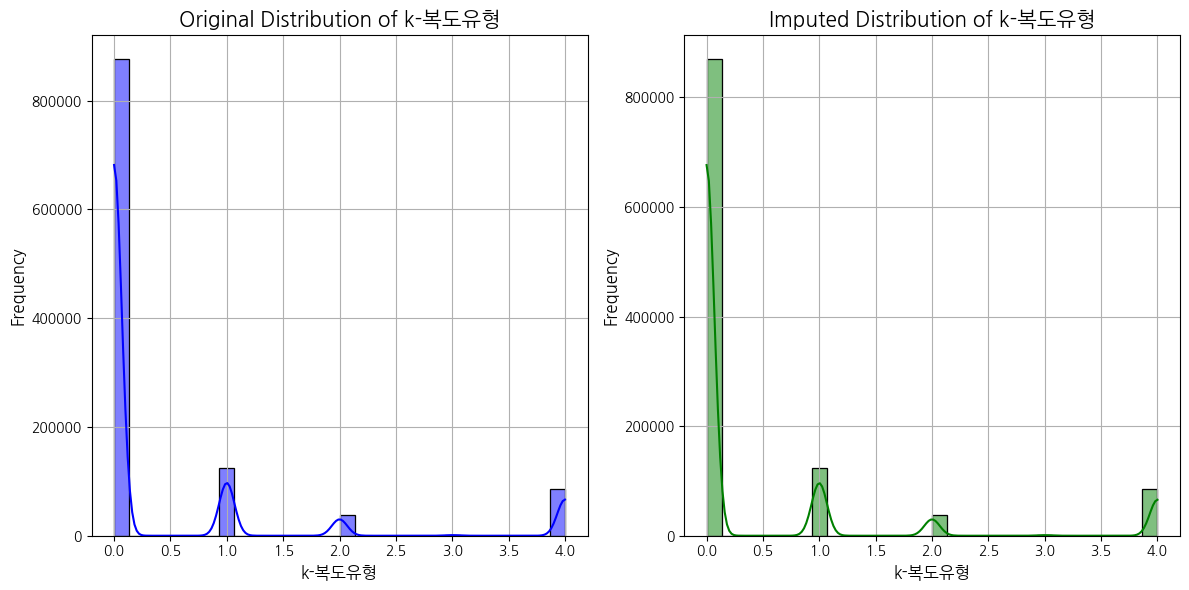

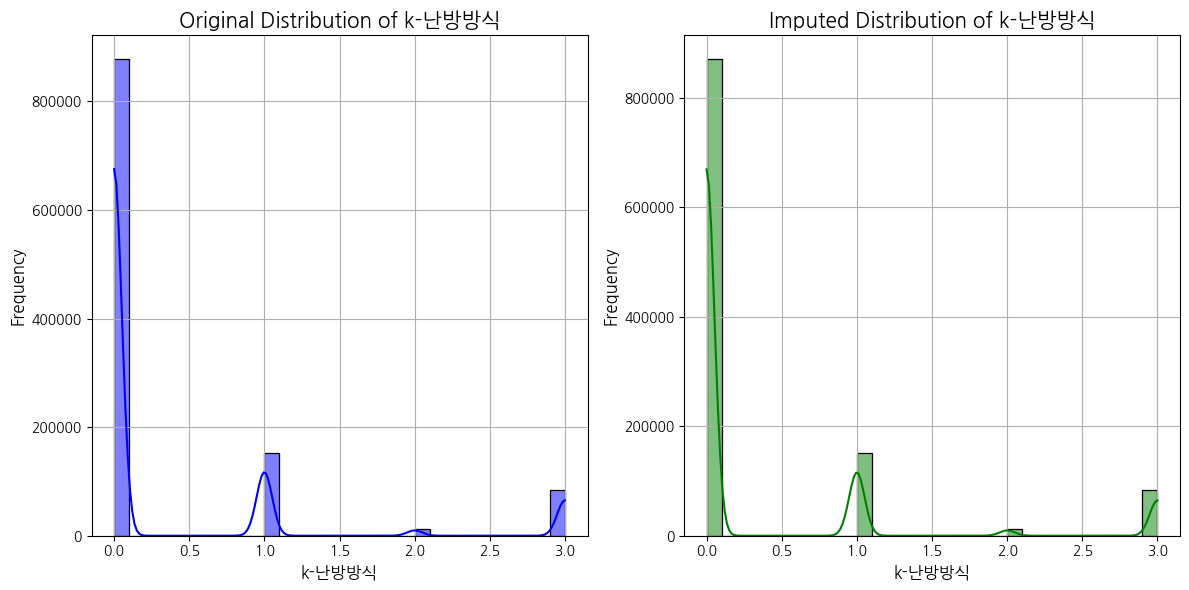

In [9]:
for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    
    # 예측 이전 분포
    plt.subplot(1, 2, 1)
    sns.histplot(original_data[column].dropna(), kde=True, bins=30, color='blue', edgecolor='k')
    plt.title(f'Original Distribution of {column}', fontsize=15)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    
    # 예측 이후 분포
    plt.subplot(1, 2, 2)
    sns.histplot(train_data[column].dropna(), kde=True, bins=30, color='green', edgecolor='k')
    plt.title(f'Imputed Distribution of {column}', fontsize=15)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
train_df = df[df['is_test'] == 0]
test_df = df[df['is_test'] == 1]

train_df = train_df.drop(columns=['is_test'])
test_df = test_df.drop(columns=['is_test', 'target'])
print(train_df.shape, test_df.shape)

train_df.to_csv(f'{data_path}/new/new_train_ver7.csv', index=False)
test_df.to_csv(f'{data_path}/new/new_test_ver7.csv', index=False)

(1118822, 184) (9272, 183)
